In [ ]:
#Türkçe IMDB yorumlarından olumlu olumsuz sınıflandırma



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Turkish_IMDB_Dataset.csv to Turkish_IMDB_Dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv("Turkish_IMDB_Dataset.csv")  # dosya adın buysa
df.columns
df.head()


,review,sentiment
0,"Diğer yorumculardan biri, sadece 1 Oz bölümünü...",pozitif
1,Harika bir küçük prodüksiyon. <br /><br />Çeki...,pozitif
2,Çok sıcak bir yaz hafta sonunda vakit geçirmek...,pozitif
3,"Temel olarak, küçük bir çocuğun (Jake) dolabın...",negatif
4,Petter Mattei'nin Love in the Time of Money fi...,pozitif


In [ ]:
#Veri önişleme ve temilzik

import re
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words=set(stopwords.words("turkish"))

#tükrçe stopword listesini alma
#temizleme fonskitonu
def temizle_metin(metin):

  metin= str(metin).lower()#küçük harf formatı
  metin=re.sub(r'<.*?>', '', metin)#html bozuk format parçalarını temizleme
  metin= metin.translate(str.maketrans('','',string.punctuation))# noktalama
  metin=re.sub(r'\d+','',metin)# sayıları temizleme
  kelimeler=metin.split()#metni kelimelere ayırır
  kelimeler = [k for k in kelimeler if k not in stop_words]#stopwords kelimeleri
  #temilzeme

  return " ".join(kelimeler)

#her yorumu temizleyip yeni sğtuna ekleme
df["temiz_review"] = df["review"].apply(temizle_metin)# uygulama aşaması
#daha sonra kontrol etme
df[["review","temiz_review","sentiment"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,temiz_review,sentiment
0,"Diğer yorumculardan biri, sadece 1 Oz bölümünü...",diğer yorumculardan sadece oz bölümünü izledik...,pozitif
1,Harika bir küçük prodüksiyon. <br /><br />Çeki...,harika bir küçük prodüksiyon çekim tekniği müt...,pozitif
2,Çok sıcak bir yaz hafta sonunda vakit geçirmek...,sıcak bir yaz hafta sonunda vakit geçirmek bun...,pozitif
3,"Temel olarak, küçük bir çocuğun (Jake) dolabın...",temel olarak küçük bir çocuğun jake dolabında ...,negatif
4,Petter Mattei'nin Love in the Time of Money fi...,petter matteinin love in the time of money fil...,pozitif


In [ ]:
print(df["temiz_review"].head(10))
print("Toplam geçerli yorum:", df["temiz_review"].notnull().sum())


0    diğer yorumculardan sadece oz bölümünü izledik...
1    harika bir küçük prodüksiyon çekim tekniği müt...
2    sıcak bir yaz hafta sonunda vakit geçirmek bun...
3    temel olarak küçük bir çocuğun jake dolabında ...
4    petter matteinin love in the time of money fil...
5    muhtemelen zamanların sevdiğim filmi özveri fe...
6    günümüzdeki teknolojiyle güncellenmiş bir seah...
7    dizi ilk yayınlandığı lerde harika taze yenili...
8    buradaki film hakkındaki olumlu yorumlardan ce...
9    orijinal mide bulandırıcı kahkahaları seviyors...
Name: temiz_review, dtype: object
Toplam geçerli yorum: 49366


In [ ]:
#CountVectorizer

"""
Modelin anlayabilmesi için metinlerin sayılarla ifade edilmesi gereklidir
metni kelime sayılarına dayalı bir vektöre dönüştürür

fit_transform() tüm kelimeleri öğrenir metinlere dönüştürür

max_features=5000 en sık geçen 5000 kelimeye göre sıralama yapar
(overfittingi önlemek için)

"""

from sklearn.feature_extraction.text import CountVectorizer

#  Vektörleştirici tanımlanıyor
cv = CountVectorizer(max_features=5000)

#  Sadece temiz_review sütununa uygula
X_count = cv.fit_transform(df["temiz_review"])

#  Hedef değişken (sentiment)
y = df["sentiment"]

#  Boyutu yazdır
print("Vektör boyutu:", X_count.shape)


Vektör boyutu: (49366, 5000)


In [ ]:
#TF-IDF Vectorizer

#kelimenin hem sıklığına hem de tüm belgelerde ne kadar özel olduğuna
#bakar

"""
"film", "çok", "bir" gibi kelimeler her belgede geçer → önemsiz

"muhteşem", "berbat", "başyapıt" gibi kelimeler az belgede geçer ama bilgi taşır → önemli

TF-IDF bu farkı yakalar.

"""


from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
#vektöürleştirici tnaımlama

X_tfidf = tfidf.fit_transform(df["temiz_review"])
#temiz yorumlara uygulama

print("TF-IDF Vektör boyutu",X_tfidf.shape)


TF-IDF Vektör boyutu (49366, 5000)


In [ ]:
#Naive Bayes Modeli ile Duygu Sınıflandırması

#TF-IDF ile sayısallaştırılan yorumlara bakarak
#yorumun pozitif mi negatif mi olduğunu tahmin eden model oluşturur

"""
Neden Naive Bayes?
Metin sınıflandırmada en çok kullanılan modellerden biridir.

Özellikle TF-IDF ile çok uyumlu çalışır.

Hızlı, basit, ama çoğu zaman güçlü sonuç verir.

"""


from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

X_train,X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
# %80'e %20 eğitim ve test verisi ayrıldı

model=MultinomialNB()
#model oluşturma
model.fit(X_train, y_train)
#eğitime

y_pred= model.predict(X_test)
#Tahmin yapma

print("Doğruluk Skoru:",accuracy_score(y_test,y_pred))
print("\nSınıflandırma Raporu:\n",classification_report(y_test,y_pred))

Doğruluk Skoru: 0.8653028154749848

Sınıflandırma Raporu:
               precision    recall  f1-score   support

     negatif       0.87      0.86      0.87      4953
     pozitif       0.86      0.87      0.87      4921

    accuracy                           0.87      9874
   macro avg       0.87      0.87      0.87      9874
weighted avg       0.87      0.87      0.87      9874



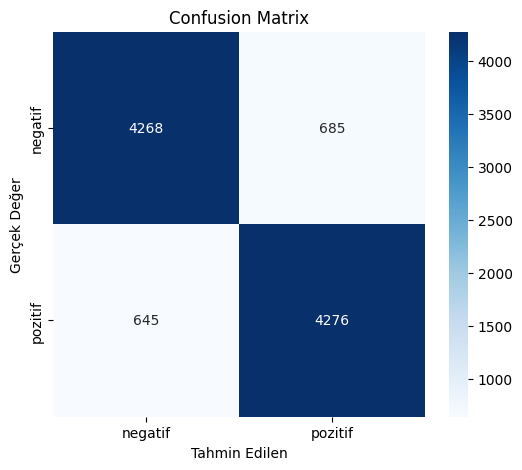

In [ ]:
#Confusion Matrix Çizimi


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(y_test,y_pred)
#matrisin hexaplanması

etiketler = ["negatif","pozitif"]


plt.figure(figsize=(6,5))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=etiketler, yticklabels=etiketler)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def temizle_metin(metin):

  metin= str(metin).lower()
  metin = re.sub(r'<.*?>','',metin)
  metin = metin.translate(str.maketrans('', '', string.punctuation))
  metin = re.sub(r'\d+','',metin)
  kelimeler= metin.split()
  kelimeler = [k for k in kelimeler if k not in stop_words]
  return " ".join(kelimeler)


def yorum_tahmin_et():

  yorum = input("Filmle İlgili Düşünceleriniz Nelerdir?")
  temiz= temizle_metin(yorum)
  vektor= tfidf.transform([temiz])
  tahmin= model.predict(vektor)[0]

  print(f"\n Yorumunuzun duygu analizi sonucu: **{tahmin.upper()}**")

yorum_tahmin_et()

Filmle İlgili Düşünceleriniz Nelerdir?Gerçekten çok sürükleyiciydi, bayıldım!

 Yorumunuzun duygu analizi sonucu: **POZITIF**
